# Iris Dataset - MLP

### [dataset](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

License: MIT

## Install Libraries

In [326]:
# !python -m pip install --upgrade pip
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124
# %pip install pandas matplotlib
# %pip install scikit-learn

## Import Libraries

In [327]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Seed

In [328]:
SEED = 42
SEED

42

In [329]:
torch.manual_seed(SEED)

## Parameters

In [330]:
IN_FEATURES=4
IN_FEATURES

4

In [331]:
H1=8
H1

8

In [332]:
H2=8
H2

8

In [333]:
OUT_FEATURES=3
OUT_FEATURES

3

In [334]:
TEST_SIZE=0.3
TEST_SIZE

0.3

In [335]:
MODE = "classification"  # "classification" or "regression"
MODE

'classification'

In [ ]:
DATA_PATH = "iris.csv"
DATA_PATH

'iris.csv'

## Hyperparameters

In [337]:
LR = 0.01
LR

0.01

In [338]:
EPOCHS = 100
EPOCHS

100

In [339]:
LOG_INTERVAL = 10
LOG_INTERVAL

10

In [340]:
BATCH_SIZE = 32  # Adjust based on dataset size (32-2048 typical)
BATCH_SIZE

32

In [341]:
CHUNK_SIZE = None  # Set to int (e.g., 100000) for large files, None for small files
CHUNK_SIZE

In [342]:
DROPOUT = 0.0  # Dropout rate (0.0 = no dropout, 0.2-0.5 typical for regularization)
DROPOUT

0.0

## Load Dataset

In [343]:
if CHUNK_SIZE is None:
    df = pd.read_csv(DATA_PATH)
else:
    chunks = []
    for chunk in pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE):
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)
    del chunks  # Free memory
    
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Clean Dataset

In [345]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [346]:
df["species"] = df["species"].map({
    "setosa": 0,
    "versicolor": 1,
    "virginica": 2,
})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Feature Statistical Significance (P-Values)

In [347]:
feature_cols = [col for col in df.columns if col != "species"]
X_stats = df[feature_cols].values
y_stats = df["species"].values

In [348]:
if MODE == "classification":
    f_scores, p_values = f_classif(X_stats, y_stats)
else:
    f_scores, p_values = f_regression(X_stats, y_stats)
    
f_scores, p_values

(array([ 119.26450218,   47.3644614 , 1179.0343277 ,  959.32440573]),
 array([1.66966919e-31, 1.32791652e-16, 3.05197580e-91, 4.37695696e-85]))

In [349]:
test_name = "ANOVA F-test" if MODE == "classification" else "F-regression"
print(f"Feature Statistical Significance ({test_name})")
print("=" * 55)
print(f"{'Feature':<20} {'F-Score':>12} {'P-Value':>15} {'Significant?':>10}")
print("-" * 55)
for feat, f_score, p_val in zip(feature_cols, f_scores, p_values):
    sig = "✓ Yes" if p_val < 0.05 else "✗ No"
    print(f"{feat:<20} {f_score:>12.2f} {p_val:>15.2e} {sig:>10}")
print("-" * 55)
print("Note: P-value < 0.05 indicates statistically significant feature")

Feature Statistical Significance (ANOVA F-test)
Feature                   F-Score         P-Value Significant?
-------------------------------------------------------
sepal_length               119.26        1.67e-31      ✓ Yes
sepal_width                 47.36        1.33e-16      ✓ Yes
petal_length              1179.03        3.05e-91      ✓ Yes
petal_width                959.32        4.38e-85      ✓ Yes
-------------------------------------------------------
Note: P-value < 0.05 indicates statistically significant feature


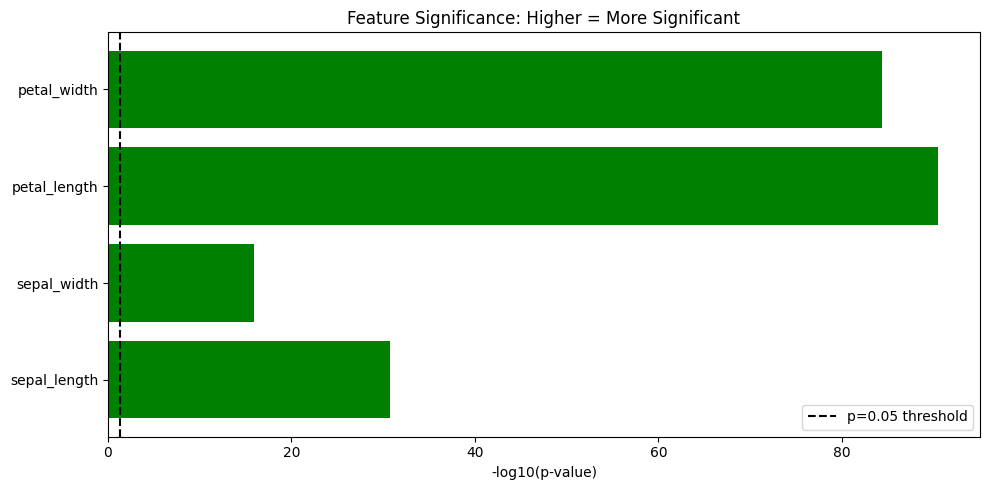

In [350]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["green" if p < 0.05 else "red" for p in p_values]
bars = ax.barh(feature_cols, -np.log10(p_values), color=colors)
ax.axvline(x=-np.log10(0.05), color="black", linestyle="--", label="p=0.05 threshold")
ax.set_xlabel("-log10(p-value)")
ax.set_title("Feature Significance: Higher = More Significant")
ax.legend()
plt.tight_layout()
plt.show()

## Create Model

In [351]:
class Model(nn.Module):
    """
    A feedforward neural network with two hidden layers and optional dropout.
    """

    def __init__(self, in_features=IN_FEATURES, h1=H1, h2=H2, out_features=OUT_FEATURES, dropout=DROPOUT):
        """
        Initializes the neural network layers.

        Parameters:
            in_features (int): Number of input features.
            h1 (int): Number of neurons in the first hidden layer.
            h2 (int): Number of neurons in the second hidden layer.
            out_features (int): Number of output features.
            dropout (float): Dropout rate (0.0 = no dropout).

        Returns:
            None
        """
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

## Instantiate Model

In [352]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
model = Model().to(DEVICE)
model

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [353]:
next(model.parameters()).device

device(type='cuda', index=0)

## Train-Test Split

In [354]:
X = df.drop("species", axis=1).values.astype("float32")
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [355]:
X.shape

(150, 4)

In [356]:
if MODE == "classification":
    y = df["species"].values.astype("int64")
else:
    y = df["species"].values.astype("float32")
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [357]:
y.shape

(150,)

In [358]:
if MODE == "classification":
    train_idx, test_idx = train_test_split(
        np.arange(len(X)), test_size=TEST_SIZE, random_state=SEED, stratify=y
    )
else:
    train_idx, test_idx = train_test_split(
        np.arange(len(X)), test_size=TEST_SIZE, random_state=SEED
    )
    
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
len(train_idx), len(test_idx)

(105, 45)

In [359]:
X_train

array([[5.1, 2.5, 3. , 1.1],
       [6.2, 2.2, 4.5, 1.5],
       [5.1, 3.8, 1.5, 0.3],
       [6.8, 3.2, 5.9, 2.3],
       [5.7, 2.8, 4.1, 1.3],
       [6.7, 3. , 5.2, 2.3],
       [4.9, 3.1, 1.5, 0.1],
       [5.1, 3.8, 1.6, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [7.1, 3. , 5.9, 2.1],
       [6.5, 3.2, 5.1, 2. ],
       [4.9, 3. , 1.4, 0.2],
       [5. , 3. , 1.6, 0.2],
       [6. , 2.9, 4.5, 1.5],
       [5.5, 2.4, 3.8, 1.1],
       [7.2, 3.2, 6. , 1.8],
       [5. , 3.4, 1.6, 0.4],
       [4.7, 3.2, 1.6, 0.2],
       [6.7, 3.3, 5.7, 2.5],
       [5.9, 3.2, 4.8, 1.8],
       [5.4, 3.4, 1.5, 0.4],
       [6.3, 2.7, 4.9, 1.8],
       [7.6, 3. , 6.6, 2.1],
       [7.7, 2.8, 6.7, 2. ],
       [5.7, 3. , 4.2, 1.2],
       [4.6, 3.4, 1.4, 0.3],
       [5.1, 3.7, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [6.9, 3.1, 4.9, 1.5],
       [5.5, 2.5, 4. , 1.3],
       [5.7, 4.4, 1.5, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.8, 2.7, 4.1, 1. ],
       [5.6, 2.9, 3.6, 1.3],
       [4.8, 3

In [360]:
X_train.shape

(105, 4)

In [361]:
y_train

array([1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 2,
       2, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0,
       2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2,
       2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0])

In [362]:
y_train.shape

(105,)

In [363]:
X_test

array([[7.3, 2.9, 6.3, 1.8],
       [6.1, 2.9, 4.7, 1.4],
       [6.3, 2.8, 5.1, 1.5],
       [6.3, 3.3, 4.7, 1.6],
       [6.1, 3. , 4.9, 1.8],
       [6.7, 3.1, 5.6, 2.4],
       [5.5, 2.3, 4. , 1.3],
       [5.6, 2.5, 3.9, 1.1],
       [5.4, 3.4, 1.7, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [5.8, 4. , 1.2, 0.2],
       [4.4, 3. , 1.3, 0.2],
       [6.7, 2.5, 5.8, 1.8],
       [6.5, 3. , 5.5, 1.8],
       [5.2, 3.4, 1.4, 0.2],
       [6.2, 3.4, 5.4, 2.3],
       [4.9, 2.4, 3.3, 1. ],
       [5.4, 3.7, 1.5, 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [5.7, 3.8, 1.7, 0.3],
       [6.2, 2.9, 4.3, 1.3],
       [5. , 3.4, 1.5, 0.2],
       [6.6, 3. , 4.4, 1.4],
       [6.5, 3. , 5.8, 2.2],
       [6. , 3. , 4.8, 1.8],
       [6.4, 3.2, 4.5, 1.5],
       [5.4, 3. , 4.5, 1.5],
       [5. , 2.3, 3.3, 1. ],
       [5.6, 3. , 4.5, 1.5],
       [5. , 3.2, 1.2, 0.2],
       [6.1, 2.6, 5.6, 1.4],
       [6.4, 2.8, 5.6, 2.2],
       [6. , 3.4, 4.5, 1.6],
       [5. , 3.3, 1.4, 0.2],
       [6.4, 2

In [364]:
X_test.shape

(45, 4)

In [365]:
y_test

array([2, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 1, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2,
       1])

In [366]:
y_test.shape

(45,)

## Create Custom Dataset (Memory Efficient)

In [367]:
class NumpyDataset(torch.utils.data.Dataset):
    """
    A memory-efficient dataset that keeps data as numpy arrays.
    Converts to tensors only when batching (on-demand).
    """

    def __init__(self, X, y, device, mode="classification"):
        """
        Initializes the dataset with numpy arrays.

        Parameters:
            X (np.ndarray): Feature array.
            y (np.ndarray): Label array.
            device (torch.device): Device to move tensors to.
            mode (str): "classification" or "regression".

        Returns:
            None
        """
        self.X = X
        self.y = y
        self.device = device
        self.mode = mode

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns a single sample as tensors on the specified device.

        Parameters:
            idx (int): Index of the sample.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Feature and label tensors.
        """
        X_tensor = torch.tensor(self.X[idx]).float().to(self.device)
        
        if self.mode == "classification":
            y_tensor = torch.tensor(self.y[idx]).long().to(self.device)
        else:
            y_tensor = torch.tensor(self.y[idx]).float().to(self.device)
        return X_tensor, y_tensor

## Create DataLoaders

In [368]:
train_dataset = NumpyDataset(X_train, y_train, DEVICE, MODE)
test_dataset = NumpyDataset(X_test, y_test, DEVICE, MODE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_loader), len(test_loader)

(4, 2)

## Create Loss Function & Optimizer

In [369]:
if MODE == "classification":
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MSELoss()
criterion

CrossEntropyLoss()

In [370]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)

## Train Model

In [371]:
train_losses = []
val_losses = []
train_losses, val_losses

([], [])

In [372]:
for i in range(EPOCHS):
    model.train()
    
    epoch_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()

    epoch_val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_val_pred = model(X_batch)
            epoch_val_loss += criterion(y_val_pred, y_batch).item()
    val_loss = epoch_val_loss / len(test_loader)
    val_losses.append(val_loss)

    if i % LOG_INTERVAL == 0:
        print(f"Epoch {i}/{EPOCHS} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

Epoch 0/100 - Training Loss: 1.1716 - Validation Loss: 1.1242
Epoch 10/100 - Training Loss: 0.7547 - Validation Loss: 0.7739
Epoch 20/100 - Training Loss: 0.3467 - Validation Loss: 0.3254
Epoch 30/100 - Training Loss: 0.1338 - Validation Loss: 0.1464
Epoch 40/100 - Training Loss: 0.0927 - Validation Loss: 0.1103
Epoch 50/100 - Training Loss: 0.0644 - Validation Loss: 0.0795
Epoch 60/100 - Training Loss: 0.0793 - Validation Loss: 0.0802
Epoch 70/100 - Training Loss: 0.0596 - Validation Loss: 0.0658
Epoch 80/100 - Training Loss: 0.0557 - Validation Loss: 0.0589
Epoch 90/100 - Training Loss: 0.0787 - Validation Loss: 0.0535


## Evaluate Model

In [373]:
model.eval()

total_val_loss = 0.0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_eval = model(X_batch)
        total_val_loss += criterion(y_eval, y_batch).item()
val_loss = total_val_loss / len(test_loader)

In [374]:
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.0549


In [375]:
model.eval()

if MODE == "classification":
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            preds = model(X_batch).argmax(dim=1)
            train_correct += (preds == y_batch).sum().item()
            train_total += len(y_batch)

        for X_batch, y_batch in test_loader:
            preds = model(X_batch).argmax(dim=1)
            test_correct += (preds == y_batch).sum().item()
            test_total += len(y_batch)

    train_acc = train_correct / train_total
    test_acc = test_correct / test_total
    
    print(f"Train Accuracy: {train_acc:.4f} ({train_correct}/{train_total})")
    print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
else:
    train_preds_list = []
    train_targets_list = []
    test_preds_list = []
    test_targets_list = []

    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            preds = model(X_batch).squeeze()
            train_preds_list.append(preds.cpu().numpy())
            train_targets_list.append(y_batch.cpu().numpy())

        for X_batch, y_batch in test_loader:
            preds = model(X_batch).squeeze()
            test_preds_list.append(preds.cpu().numpy())
            test_targets_list.append(y_batch.cpu().numpy())

    train_preds_np = np.concatenate(train_preds_list)
    train_targets_np = np.concatenate(train_targets_list)
    test_preds_np = np.concatenate(test_preds_list)
    test_targets_np = np.concatenate(test_targets_list)

    train_r2 = r2_score(train_targets_np, train_preds_np)
    test_r2 = r2_score(test_targets_np, test_preds_np)
    train_mse = mean_squared_error(train_targets_np, train_preds_np)
    test_mse = mean_squared_error(test_targets_np, test_preds_np)
    train_mae = mean_absolute_error(train_targets_np, train_preds_np)
    test_mae = mean_absolute_error(test_targets_np, test_preds_np)

    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

Train Accuracy: 0.9905 (104/105)
Test Accuracy: 0.9778 (44/45)
Training Loss: 0.0516
Validation Loss: 0.0549


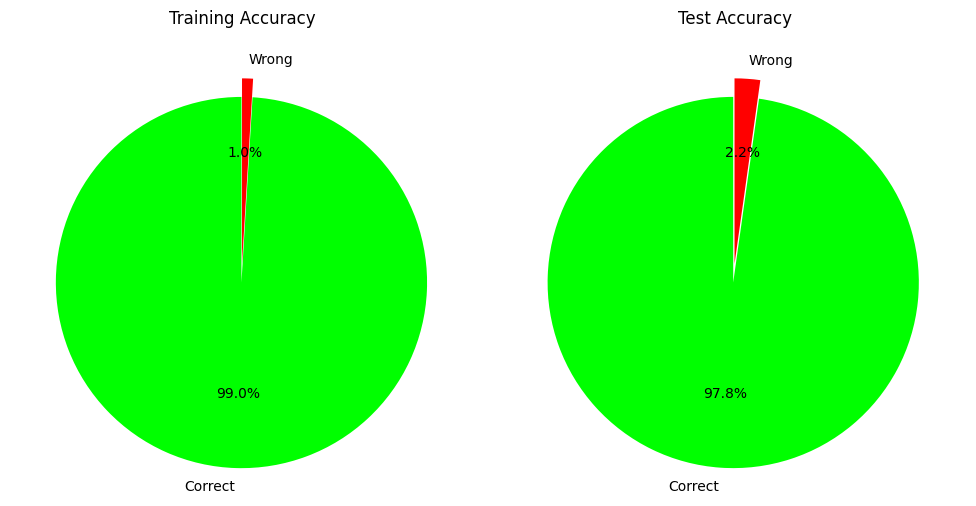

In [376]:
if MODE == "classification":
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    colors = ["#00FF00", "#FF0000"]  # Green for correct, red for wrong
    ax1.pie([train_acc, 1 - train_acc], 
            labels=["Correct", "Wrong"], 
            autopct="%1.1f%%", 
            colors=colors, 
            startangle=90, 
            explode=(0.1, 0))
    ax1.set_title("Training Accuracy")
    ax2.pie([test_acc, 1 - test_acc], 
            labels=["Correct", "Wrong"], 
            autopct="%1.1f%%", 
            colors=colors, 
            startangle=90, 
            explode=(0.1, 0))
    ax2.set_title("Test Accuracy")
    plt.tight_layout()
    plt.show()
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(train_targets_np, train_preds_np, alpha=0.5)
    ax1.plot([train_targets_np.min(), train_targets_np.max()], 
             [train_targets_np.min(), train_targets_np.max()], "r--", lw=2)
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    ax1.set_title(f"Train: Actual vs Predicted (R²={train_r2:.4f})")
    ax2.scatter(test_targets_np, test_preds_np, alpha=0.5)
    ax2.plot([test_targets_np.min(), test_targets_np.max()], 
             [test_targets_np.min(), test_targets_np.max()], "r--", lw=2)
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.set_title(f"Test: Actual vs Predicted (R²={test_r2:.4f})")
    plt.tight_layout()
    plt.show()

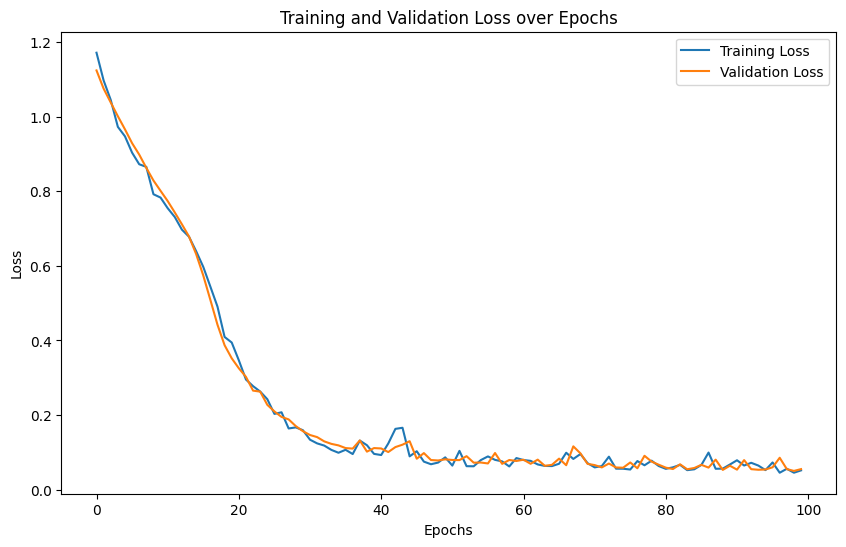

In [377]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

## Save Model

In [378]:
torch.save(model.state_dict(), "iris_model.pth")
print("Model saved to iris_model.pth")

Model saved to iris_model.pth


## Load Model

In [379]:
loaded_model = Model().to(DEVICE)
loaded_model.load_state_dict(torch.load("iris_model.pth", map_location=DEVICE))
loaded_model.eval()
print("Model loaded from iris_model.pth")

Model loaded from iris_model.pth


## Inference

In [380]:
def predict(model, features, mode=MODE):
    """
    Make a prediction on new data.

    Parameters:
        model (nn.Module): Trained PyTorch model.
        features (list[float]): List of feature values.
        mode (str): "classification" or "regression".

    Returns:
        tuple[str, float] | float: For classification: (class_name, confidence).
                                   For regression: predicted value.
    """
    species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}

    model.eval()
    
    with torch.no_grad():
        X_new = torch.tensor(features).float().to(DEVICE)
        
        if X_new.dim() == 1:
            X_new = X_new.unsqueeze(0)
        logits = model(X_new)
        if mode == "classification":
            probabilities = torch.softmax(logits, dim=1)
            predicted_class = logits.argmax(dim=1).item()
            confidence = probabilities[0][predicted_class].item()
            return species_map[predicted_class], confidence
        else:
            return logits.squeeze().item()

In [381]:
# Example: New flower measurements [sepal_length, sepal_width, petal_length, petal_width]
new_flower = [5.1, 3.5, 1.4, 0.2]

if MODE == "classification":
    species, confidence = predict(model, new_flower)
    print(f"Input: {new_flower}")
    print(f"Predicted Species: {species}")
    print(f"Confidence: {confidence:.2%}")
else:
    prediction = predict(model, new_flower)
    print(f"Input: {new_flower}")
    print(f"Predicted Value: {prediction:.4f}")

Input: [5.1, 3.5, 1.4, 0.2]
Predicted Species: setosa
Confidence: 99.91%
